In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/EE541"

/content/drive/My Drive/EE541


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

data = pd.DataFrame(np.load("/content/drive/My Drive/EE541/dataset_melspectrogram.npy",allow_pickle= True))
data.columns = ['feature', 'label']


In [ ]:
X = np.array(data.feature.tolist())
y = np.array(data.label.tolist())

# Split the data into 70% train and 30% remaining
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the remaining 30% into half to get 15% validation and 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
label_dict = {'dog_bark' : 0, 'children_playing' : 1, 'car_horn' : 2, 'air_conditioner' : 3,
       'street_music' : 4, 'gun_shot' : 5, 'siren' : 6, 'engine_idling' : 7, 'jackhammer' : 8,
       'drilling' : 9}

ly = []
lvay = []
ltesty = []

for i in y_train:
    ly.append(label_dict[i])

for i in y_val:
    lvay.append(label_dict[i])

for i in y_test:
    ltesty.append(label_dict[i])

In [ ]:
X = torch.from_numpy(X_train)
val_x = torch.from_numpy(X_val)
test_x = torch.from_numpy(X_test)
y = torch.from_numpy(np.array(ly))
val_y = torch.from_numpy(np.array(lvay))
test_y = torch.from_numpy(np.array(ltesty))

print(y)

tensor([3, 9, 1,  ..., 3, 6, 6])


In [ ]:
from torch.utils.data import TensorDataset

train_set = TensorDataset(X.unsqueeze(1), y)
val_set = TensorDataset(val_x.unsqueeze(1), val_y)
test_set = TensorDataset(test_x.unsqueeze(1), test_y)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 128, shuffle = True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = 128, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = True, **kwargs)

In [ ]:
###DenseNet
def conv_block(in_channel, out_channel):
    layer = nn.Sequential(
        nn.BatchNorm1d(in_channel),
        nn.ReLU(True),
        nn.Conv1d(in_channel, out_channel, 3, padding=1, bias=False)
    )
    return layer

class dense_block(nn.Module):
    def __init__(self, in_channel, growth_rate, num_layers):
        super(dense_block, self).__init__()
        block = []
        channel = in_channel
        for i in range(num_layers):
            block.append(conv_block(channel, growth_rate))
            channel += growth_rate

        self.net = nn.Sequential(*block)

    def forward(self, x):
        for layer in self.net:
            out = layer(x)
            x = torch.cat((out, x), dim=1)
        return x

def transition(in_channel, out_channel):
    trans_layer = nn.Sequential(
        nn.BatchNorm1d(in_channel),
        nn.ReLU(True),
        nn.Conv1d(in_channel, out_channel, 1)
    )
    return trans_layer


class Densenet(nn.Module):
    def __init__(self):
        super(Densenet, self).__init__()

        self.conv1 = nn.Conv1d(1, 128, 3, padding = 1)

        self.block1 = nn.Sequential(
            nn.Conv1d(128, 256, 3, 1, 1),
            nn.BatchNorm1d(256),
            nn.ReLU(True)
        )

        growth_rate=32
        block_layers=[4, 8, 16, 14]


        channels = 256
        block = []
        for i, layers in enumerate(block_layers):
            block.append(dense_block(channels, growth_rate, layers))
            channels += layers * growth_rate
            if i != len(block_layers) - 1:
                block.append(transition(channels, channels // 2)) # 通过 transition 层将大小减半，通道数减半
                channels = channels // 2

        self.block2 = nn.Sequential(*block)
        self.block2.add_module('bn', nn.BatchNorm1d(channels))
        self.block2.add_module('relu', nn.ReLU(True))
        self.block2.add_module('avg_pool', nn.AvgPool1d(1))


        self.avgPool = nn.AvgPool1d(40)
        self.fc1 = nn.Linear(816, 10)



    def forward(self, x):

        x = self.conv1(x)
        #print(x.shape)
        x = self.block1(x)
        #print(x.shape)
        x = self.block2(x)
        #print(x.shape)
        x = self.avgPool(x)
        #print(x.shape)
        x = x.permute(0, 2, 1) #change the 512x1 to 1x512
        x = self.fc1(x)
        return F.log_softmax(x, dim = 2)

model = Densenet()
model.to(device)
print(model)

Densenet(
  (conv1): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (block1): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): dense_block(
      (net): Sequential(
        (0): Sequential(
          (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv1d(256, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        )
        (1): Sequential(
          (0): BatchNorm1d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv1d(288, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        )
        (2): Sequential(
          (0): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)

In [ ]:
def train(model, epoch):
    model.train()
    correct = 0
    total = 0
    total_loss = 0  # Initialize total loss for the epoch

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        data = data.requires_grad_()  # Set requires_grad to True for training
        output = model(data)
        output = output.permute(1, 0, 2)  # Original output dimensions are batchSizex1x10
        target = target.to(torch.int64)
        loss = F.nll_loss(output[0], target)  # The loss function expects a batchSizex10 input
        total_loss += loss.item()  # Accumulate the loss
        loss.backward()
        optimizer.step()

        # Calculate correct predictions
        pred = output.max(2)[1]  # Get the index of the max log-probability
        correct += pred.eq(target).sum().item()
        total += target.size(0)

    # Calculate average loss and accuracy for the epoch
    average_loss = total_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    print('Train Epoch: {} \tAverage Loss: {:.4f}\tAccuracy: {:.2f}%'.format(
        epoch, average_loss, train_accuracy))
    return average_loss, train_accuracy


In [ ]:
def val(model, epoch):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():  # No need to track gradients during validation
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            output = output.permute(1, 0, 2)
            val_loss += F.nll_loss(output[0], target, reduction='sum').item()  # Sum up batch loss
            pred = output.max(2)[1]  # Get the index of the max log-probability
            correct += pred.eq(target).cpu().sum().item()

    val_loss /= len(val_loader.dataset)  # Average loss
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return val_loss,  100. * correct / len(val_loader.dataset)


In [ ]:
def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        output = output.permute(1, 0, 2)
        pred = output.max(2)[1] # get the index of the max log-probability
        correct += pred.eq(target).cpu().sum().item()
    print('Test set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, 51):
    train_loss, train_accuracy = train(model, epoch)
    val_loss, val_accuracy = val(model, epoch)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

Train Epoch: 1 	Average Loss: 1.5900	Accuracy: 44.24%

Validation set: Average loss: 1.5658, Accuracy: 608/1310 (46%)

Train Epoch: 2 	Average Loss: 1.2234	Accuracy: 58.62%

Validation set: Average loss: 1.3374, Accuracy: 721/1310 (55%)

Train Epoch: 3 	Average Loss: 1.1004	Accuracy: 62.42%

Validation set: Average loss: 1.1868, Accuracy: 762/1310 (58%)

Train Epoch: 4 	Average Loss: 0.9796	Accuracy: 66.97%

Validation set: Average loss: 1.0209, Accuracy: 855/1310 (65%)

Train Epoch: 5 	Average Loss: 0.8398	Accuracy: 72.04%

Validation set: Average loss: 0.9877, Accuracy: 885/1310 (68%)

Train Epoch: 6 	Average Loss: 0.7597	Accuracy: 74.72%

Validation set: Average loss: 1.0815, Accuracy: 866/1310 (66%)

Train Epoch: 7 	Average Loss: 0.6665	Accuracy: 77.81%

Validation set: Average loss: 0.7159, Accuracy: 992/1310 (76%)

Train Epoch: 8 	Average Loss: 0.6194	Accuracy: 79.76%

Validation set: Average loss: 0.7410, Accuracy: 984/1310 (75%)

Train Epoch: 9 	Average Loss: 0.5275	Accuracy: 8

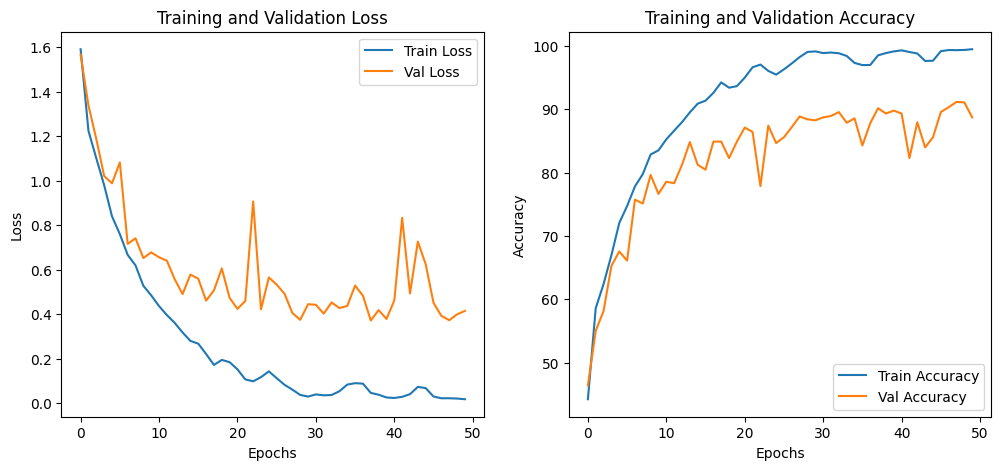

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [18]:
import pickle
with open('DenseNet_Train_LOSS.pkl', 'wb') as file:
    pickle.dump(train_losses, file)
with open('DenseNet_VAL_LOSS.pkl', 'wb') as file:
    pickle.dump(val_losses, file)
with open('DenseNet_Train_AUC.pkl', 'wb') as file:
    pickle.dump(train_accuracies, file)
with open('DenseNet_VAL_AUC.pkl', 'wb') as file:
    pickle.dump(val_accuracies, file)